## Section 1: Import Necessary Libraries

In [1]:
import numpy as np
import math
import re # regular expression
import pandas as pd
from bs4 import BeautifulSoup #Text pre-processing
from google.colab import drive
import zipfile
import seaborn as sns #Data visualization
from string import digits, punctuation
import spacy as sp
import random
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%tensorflow_version 2.x
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [3]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Section 2: Pre processing

#### Dataset upload

In [4]:
# get dataset from google drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Extract the file in the root folder of Colab
path = '/content/drive/My Drive/nlp-getting-started.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

In [0]:
path_to_file = '/content/train.csv'
train = pd.read_csv('/content/train.csv')

In [7]:
train.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


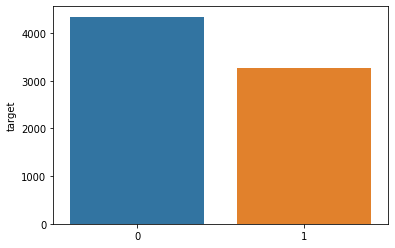

In [8]:
target_counts = train.target.value_counts()
sns.barplot(target_counts.index, target_counts)

There are two classes in the dataset, the class 0 (non-disaster) and the class 1 (disaster). The class distribution has more non-disaster tweets.

#### Basic analysis on the dataset, in character, word and sentence level.

Number of characters in a true and false disaster tweets

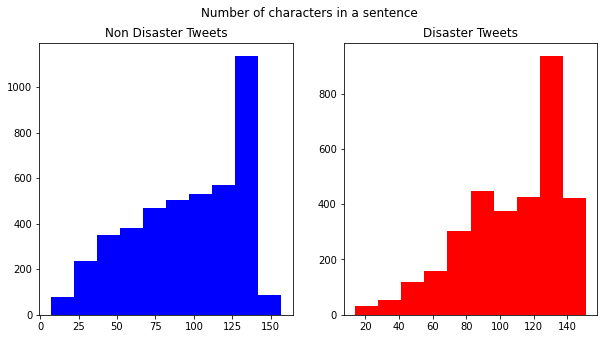

In [9]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
train_length = train[train['target']==0]['text'].str.len()
ax1.hist(train_length, color='blue')
ax1.set_title('Non Disaster Tweets')
train_length = train[train['target']==1]['text'].str.len()
ax2.hist(train_length, color='red')
ax2.set_title('Disaster Tweets')
fig.suptitle('Number of characters in a sentence')
plt.show()

The number of characters distribution of both are similar. The most common character length among both are 120 to 140. 

Number of words in a sentence.

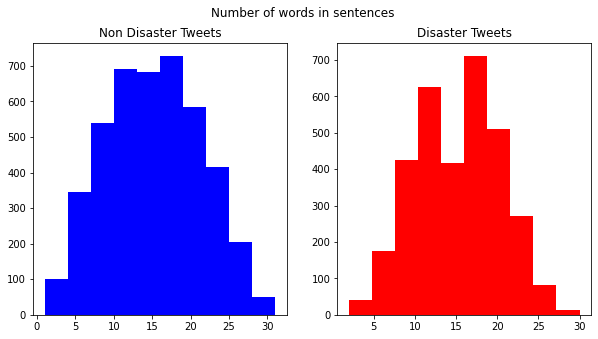

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
train_length = train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(train_length, color='blue')
ax1.set_title('Non Disaster Tweets')
train_length = train[train['target']==1]['text'].str.split().map(lambda x:len(x))
ax2.hist(train_length, color='red')
ax2.set_title('Disaster Tweets')
fig.suptitle('Number of words in sentences')
plt.show()

#### Most Used Words
verifying the 15 most used nouns and verbs in true disaster tweets

In [0]:
disaster_texts = train[train['target']==1]['text']

In [12]:
disaster_texts[7609]

'@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.'

Stop Words are used to eliminate unimportant words, allowing applications to focus on the important words instead. First it'll be removed the stop words from tweets, then clean them (remove usernames, URLs, ponctuation), tokenize and tag each word. Then plot the most 15 used words in the true disaster tweets.

In [0]:
stop_words = stopwords.words('english')

In [14]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [0]:
def stop_words_removal(tweet):
  tweet = tweet.lower()
  document = nltk.tokenize.word_tokenize(tweet)
  words = []
  new_sentence = ''
  
  for token in document:
    words.append(token)
  words = [word for word in words if word not in stop_words and word not in punctuation]

  for w in words:
    new_sentence = new_sentence+ w + ' '
  return new_sentence

In [16]:
stop_words_removal('@TheTawniest The is out of control wild fires in California even in the Northern part of the state. Very troubling.')

'thetawniest control wild fires california even northern part state troubling '

In [0]:
def clean_tweets(tweet):
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)#removing the username
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)#removing the URL
  num_digits= str.maketrans('','',digits)
  tweet= tweet.translate(num_digits)#remove digits
  tweet = stop_words_removal(tweet)
  tweet = re.sub(r" +", ' ', tweet)
  tweet = tweet.strip()
  return tweet

In [18]:
clean_tweets('@TheTawniest The out of control wild - 3454640 fires in4 California even in the Northern part of the state. Very troubling.')

'control wild fires california even northern part state troubling'

In [19]:
tokenized_disaster_text = [clean_tweets(text) for text in disaster_texts]
tokenized_disaster_text = nltk.pos_tag_sents([nltk.word_tokenize(t) for t in tokenized_disaster_text], tagset='universal')
tokenized_disaster_text[-1]

[('latest', 'ADJ'),
 ('homes', 'NOUN'),
 ('razed', 'VERB'),
 ('northern', 'ADJ'),
 ('california', 'NOUN'),
 ('wildfire', 'NOUN'),
 ('abc', 'NOUN'),
 ('news', 'NOUN')]

Tags  are in tuples inside a list of lists. So, need to withdraw them from the lists

In [20]:
tags = []
for t in tokenized_disaster_text:
  tags.extend(t)
tags[-5:]

[('northern', 'ADJ'),
 ('california', 'NOUN'),
 ('wildfire', 'NOUN'),
 ('abc', 'NOUN'),
 ('news', 'NOUN')]

In [0]:
nouns = nltk.FreqDist(word for (word, tag) in tags if tag in ['NOUN'] and word !='/' and len(word)>3)
verbs = nltk.FreqDist(word for (word, tag) in tags if tag in ['VERB'] and len(word)>1)

In [0]:
most_common_nouns = nouns.most_common(15)
x_noun_axis = [t[0] for t in most_common_nouns]
y_noun_axis = [t[1] for t in most_common_nouns]

In [0]:
most_common_verbs = verbs.most_common(15)
x_verb_axis = [t[0] for t in most_common_verbs]
y_verb_axis = [t[1] for t in most_common_verbs]

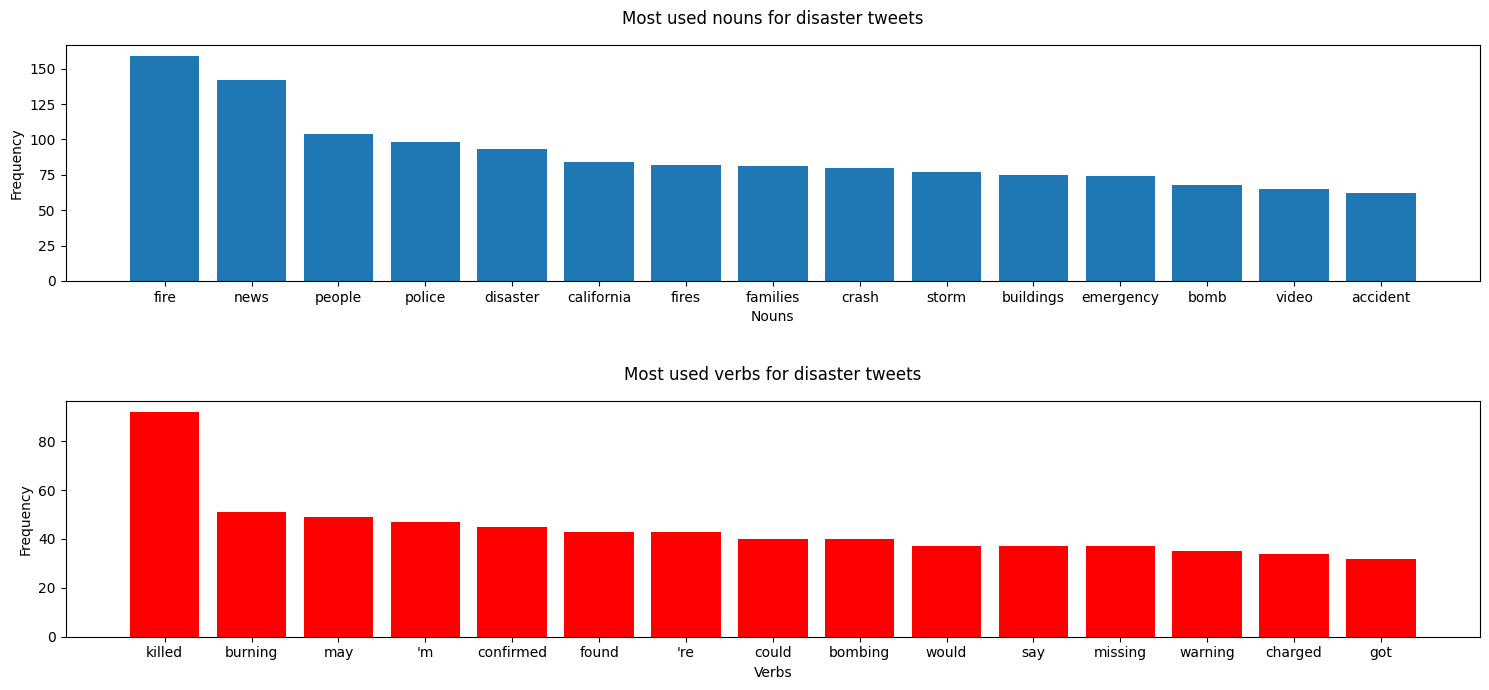

In [24]:
plt.rcdefaults()
fig = plt.figure(figsize=(15, 7))
fig.add_subplot(2,1,1)
plt.bar(x_noun_axis, y_noun_axis)
plt.xlabel('Nouns')
plt.ylabel('Frequency')
plt.title('Most used nouns for disaster tweets', pad=15.0)
fig.add_subplot(2,1,2)
plt.bar(x_verb_axis, y_verb_axis, color='red')
plt.xlabel('Verbs')
plt.ylabel('Frequency')
plt.title('Most used verbs for disaster tweets', pad=15.0)
fig.tight_layout(h_pad=3.0)

On the first bar plot the three most used noun in the true tragedie sentences was 'fire', followed by 'news' and 'disasters'. With low difference between the frequency of the first to the second and second to third.

On the second bar plot the three most used verbs were 'kill', 'burn' and 'confirm'. The difference between the first and second was almost two times, and the second and third had low difference.

#### Tokenization and Padding

In [0]:
texts = train.loc[:]['text'].values
classes = train.loc[:]['target'].values

In [0]:
cleaned_tweets = [clean_tweets(t) for t in texts]

In [0]:
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(cleaned_tweets, target_vocab_size=2**15)

In [28]:
tokenizer.vocab_size

17585

In [29]:
ids = tokenizer.encode('I am happy')
ids

[17402, 17361, 16729, 3307]

In [30]:
tokenizer.decode([17402, 17361, 16729, 3307])

'I am happy'

In [31]:
tokenized_train_sentences = [tokenizer.encode(s) for s in cleaned_tweets]
tokenized_train_sentences[random.randint(0, len(tokenized_train_sentences) -1)]

[578, 163, 1643, 4743, 71, 2132, 6832]

Pad the sentences with '0', so sentences can have all the same size

In [32]:
maxlen = max([len(sentence) for sentence in tokenized_train_sentences])
maxlen

29

In [33]:
input_tweets = tf.keras.preprocessing.sequence.pad_sequences(tokenized_train_sentences, maxlen, padding='post', value=0)
input_tweets[random.randint(0,len(input_tweets)-1)]

array([ 1735,   586, 10006,  2702,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0], dtype=int32)

In [0]:
from sklearn.model_selection import train_test_split
train_text, test_text, train_classes, test_classes = train_test_split(input_tweets, classes, test_size=0.15, stratify=classes)

In [35]:
print('Length train texts {} and Length train classes {}'.format(len(train_text), len(train_classes)))
print('Length test texts {} and Length test classes {}'.format(len(test_text), len(test_classes)))

Length train texts 6471 and Length train classes 6471
Length test texts 1142 and Length test classes 1142


## Section 3: Model

The model used in this implementation was inspired by the paper "Convolutional Recurrent Neural Networks for Text Classification" (Wang et al. 2019) that can be accessed [here](https://ieeexplore.ieee.org/document/8852406). The difference from this model to the one showed in the paper is that we used GRU instead of LSTM.  

![Model Architecture](https://drive.google.com/uc?id=1AxzyiyyPrA4yjeigUBJgTV_usM4VJN4W
)






![Convolutional Architecture](https://drive.google.com/uc?id=1I0wq4W--hH5KKqAdIOGcQbYfXx76Cp2u
)

In [0]:
class CGNN(tf.keras.Model):
  def __init__(self, vocab_size, units=512, emb_dim=128, nb_filters=50, dropout=0.1, name="cgnn"):
    super(CGNN, self).__init__(name=name)
    self.embedding= layers.Embedding(vocab_size, emb_dim)
    
    self.bigram= layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')
    self.trigram= layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')
    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')
    
    self.pool = layers.GlobalMaxPool1D()

    self.dropout = layers.Dropout(dropout)

    self.dense1 = layers.Dense(units=(units/2))
    self.dense2 = layers.Dense(units=units)

    #Bidirectional GRU
    self.forward_GRU = layers.GRU(units)
    self.backward_GRU = layers.GRU(units, go_backwards=True)
    self.bidirectional = layers.Bidirectional(self.forward_GRU, backward_layer=self.backward_GRU)

    #Dense Layers
    self.dense = layers.Dense(units=units)
    self.last_dense = layers.Dense(1, activation='sigmoid')

  def call(self, inputs, training):

    x = self.embedding(inputs)

    x1 = self.bigram(x)
    x1 = self.pool(x1)

    x2 = self.trigram(x)
    x2 = self.pool(x2)

    x3 = self.fourgram(x)
    x3 = self.pool(x3)
    
    merged = tf.concat([x1, x2, x3], -1)
    merged = tf.expand_dims(merged, 1)

    #Bidirectional GRU
    bidirec = self.bidirectional(merged)

    #Dense Layers
    output = self.dense(bidirec)
    output = self.last_dense(output)
    return output

In [0]:
vocab_size = tokenizer.vocab_size
emb_dim = 1024
nb_filters = 256
ffn_units = 1024
batch_size=64
dropout_rate = 0.2
nb_epochs = 15

In [0]:
cgnn = CGNN(vocab_size=vocab_size, emb_dim=emb_dim,
            nb_filters=nb_filters, units=ffn_units,
            dropout=dropout_rate)

In [0]:
cgnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
checkpoint_path = '/content/drive/My Drive/Convolutional_Tweets_Checkpoints'
ckpt = tf.train.Checkpoint(cgnn=cgnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored')

"if ckpt_manager.latest_checkpoint:\n  ckpt.restore(ckpt_manager.latest_checkpoint)\n  print('Latest checkpoint restored')"

In [41]:
history = cgnn.fit(input_tweets, 
                   classes,
                   batch_size=batch_size,
                   epochs = nb_epochs,
                   verbose = 1)
ckpt_manager.save()

Epoch 1/15
119/119 [==============================] - 119s 1000ms/step - loss: 0.5620 - accuracy: 0.7130
Epoch 2/15
119/119 [==============================] - 118s 993ms/step - loss: 0.2313 - accuracy: 0.9146
Epoch 3/15
119/119 [==============================] - 119s 999ms/step - loss: 0.0869 - accuracy: 0.9716
Epoch 4/15
119/119 [==============================] - 119s 997ms/step - loss: 0.0510 - accuracy: 0.9779
Epoch 5/15
119/119 [==============================] - 119s 1s/step - loss: 0.0372 - accuracy: 0.9815
Epoch 6/15
119/119 [==============================] - 120s 1s/step - loss: 0.0353 - accuracy: 0.9825
Epoch 7/15
119/119 [==============================] - 123s 1s/step - loss: 0.0335 - accuracy: 0.9817
Epoch 8/15
119/119 [==============================] - 122s 1s/step - loss: 0.0311 - accuracy: 0.9823
Epoch 9/15
119/119 [==============================] - 123s 1s/step - loss: 0.0305 - accuracy: 0.9825
Epoch 10/15
119/119 [==============================] - 122s 1s/step - loss: 0.

'/content/drive/My Drive/Convolutional_Tweets_Checkpoints/ckpt-1'

In [42]:
results = cgnn.evaluate(test_text, test_classes, batch_size=batch_size)
print(results)

18/18 [==============================] - 2s 122ms/step - loss: 0.0235 - accuracy: 0.9860
[0.02352426014840603, 0.985989511013031]


In [0]:
classes_pred_test = cgnn.predict(test_text)

In [44]:
classes_pred_test

array([[1.8331277e-06],
       [6.3651787e-06],
       [9.8201632e-04],
       ...,
       [1.7931814e-05],
       [1.0491113e-05],
       [3.3508464e-08]], dtype=float32)

In [0]:
classes_pred_test = (classes_pred_test>0.5)

In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_classes, classes_pred_test)
cm

array([[648,   3],
       [ 13, 478]])

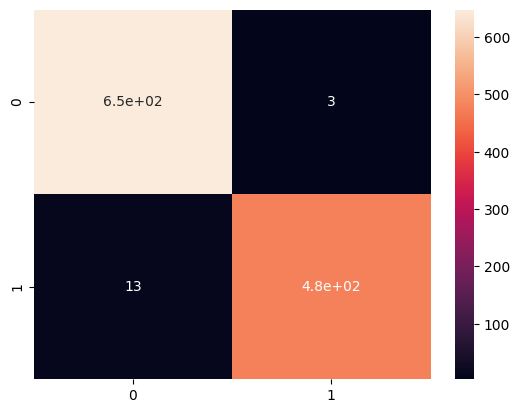

In [47]:
# Confusion Matrix
sns.heatmap(cm, annot=True)

The results was better than expected as it had only 16 wrong classifications, 3 false-negative and 13 false-positive classifications.